In [1]:
import pandas as pd
from langdetect import detect
from deep_translator import GoogleTranslator
import re
import spacy
from underthesea import word_tokenize, pos_tag
from nltk.corpus import stopwords
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_md')
stop_words = set(stopwords.words('english'))

In [3]:
csv_cr = "../../data/raw/UpdatedResumeDataSet.csv"
csv_jd_clean = "../../data/clean/clean_jobs_v2.csv"

In [4]:
df_cr = pd.read_csv(csv_cr)
df_jd = pd.read_csv(csv_jd_clean)

In [5]:
df_cr['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [6]:
list_job_to_remove = ['Sales','Health and fitness','PMO','Arts']

df_cr = df_cr[~df_cr['Category'].isin(list_job_to_remove)]

In [7]:
df_cr['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Web Designing',
       'Mechanical Engineer', 'Civil Engineer', 'Java Developer',
       'Business Analyst', 'SAP Developer', 'Automation Testing',
       'Electrical Engineering', 'Operations Manager', 'Python Developer',
       'DevOps Engineer', 'Network Security Engineer', 'Database',
       'Hadoop', 'ETL Developer', 'DotNet Developer', 'Blockchain',
       'Testing'], dtype=object)

In [8]:
df_jd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2448 entries, 0 to 2447
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2448 non-null   object
 1   title                  2081 non-null   object
 2   company                2081 non-null   object
 3   location               2081 non-null   object
 4   salary                 2081 non-null   object
 5   work_type              841 non-null    object
 6   description            2081 non-null   object
 7   requirements           2081 non-null   object
 8   language               2081 non-null   object
 9   description_clean      2081 non-null   object
 10  requirements_clean     2081 non-null   object
 11  description_en_clean   2081 non-null   object
 12  requirements_en_clean  2081 non-null   object
 13  primary_skills         2448 non-null   object
 14  secondary_skills       2448 non-null   object
 15  adjectives           

In [9]:
columns_drop = ['work_type','language','company','location','salary','description','requirements']
df_jd.drop(columns_drop, axis=1, inplace=True)

In [10]:
import ast
df_jd['primary_skills'] = df_jd['primary_skills'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
df_jd = df_jd.dropna(subset=['primary_skills'])
mask = df_jd['primary_skills'].apply(
    lambda x: isinstance(x, (list, tuple, set)) and len(x) > 0
)
df_jd = df_jd[mask].reset_index(drop=True)

In [11]:
def read_skills(file_path):
    skills = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#'):
                skills.append(line.lower())
    return skills
skills_list = read_skills('../../data/skills.txt')

In [12]:
import re
from collections import Counter
import spacy

adj_counter = Counter()
adv_counter = Counter()

def clean_text_for_matching(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    
    protected = []
    def _protect(match):
        protected.append(match.group(0))
        return f"__PROT_{len(protected)-1}__"
    
    # Bảo vệ các thuật ngữ IT như C#, C++, node.js trước mọi xử lý
    text = re.sub(r"\b\w+[#+.]\w*\b", _protect, text, flags=re.IGNORECASE)
    
    # Các bước xử lý văn bản
    text = text.lower()
    text = re.sub(r"(?<=\b\w)[-/](?=\w\b)", " ", text)
    text = re.sub(r"\s*&\s*", " ", text)
    text = re.sub(r"http\S+|@\s|\s@(?=\s)|\s#", " ", text)
    text = re.sub(r"[()]", " ", text)
    text = re.sub(r"(?<!\w)[.,!?;:–—](?!\w)", " ", text)
    text = re.sub(r"[\n\r\t]", " ", text)
    text = re.sub(r"\b\w*['’‘]\w*\b", "", text)
    text = re.sub(r"\s*[-–—]{2,}\s*", " ", text)
    text = re.sub(r"[“”‘’«»„‟]", " ", text)
    text = re.sub(r"(?<=\w)[.,!:](?=\s|$)", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"/", " ", text)
    text = re.sub(r"(?<=\w):(?=\w)", " ", text)
    text = re.sub(r"([^a-zA-Z0-9\s])\1{2,}", "", text)
    
    
    # Khôi phục các thuật ngữ được bảo vệ
    for i, word in enumerate(protected):
        text = text.replace(f"__prot_{i}__", word.lower())
    
    return text

def nomalize_skills(skills):
    return [clean_text_for_matching(skill).strip() for skill in skills]


def generate_ngrams(text, max_n=3):
    tokens = text.split()
    ngrams = []
    for n in range(1, max_n+1):
        ngrams.extend([' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
    return ngrams

def extract_skills(text):
    if not isinstance(text.lower(), str) or pd.isna(text.lower()):
        return []

    ngrams = generate_ngrams(text.lower(), max_n=3)

    found = [skill for skill in skills_list if skill in ngrams]

    return list(dict.fromkeys(found))



def extract_adjectives(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp(text)
    adjs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADJ"
        and len(token.lemma_) > 2            # loại từ ngắn như "as", "own"
        and token.is_alpha                   # bỏ từ chứa số, ký hiệu
        and not token.is_stop                # loại stop words mặc định của spaCy
    ]
    adj_counter.update(adjs)
    return list(set(adjs))

def extract_adverbs(text):
    if not isinstance(text, str) or pd.isna(text):
        return []

    doc = nlp(text)
    advs = [
        token.lemma_.lower()
        for token in doc
        if token.pos_ == "ADV"
        and len(token.lemma_) > 2
        and token.is_alpha
        and not token.is_stop
    ]
    adv_counter.update(advs)
    return list(set(advs))

In [13]:
df_cr['resume_cleaned'] = df_cr['Resume'].apply(clean_text_for_matching)

In [14]:
df_cr['skills'] = df_cr['resume_cleaned'].apply(extract_skills)

In [15]:
for i in range(len(df_cr)):
    df_cr.at[i, 'id'] = "CANDIDATE_" + str(i)

In [16]:
df_cr = df_cr.dropna()

In [17]:
pd.DataFrame(df_cr)

,Category,Resume,resume_cleaned,skills,id
0,Data Science,Skills * Programming Languages: Python (pandas...,skills * programming languages python pandas n...,"[python, java, javascript, angular, flask, jqu...",CANDIDATE_0
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 to may 2017 b.e uit...,"[machine learning, data scientist, platform]",CANDIDATE_1
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas of interest deep learning control system...,"[python, java, matlab, flask, deep learning, j...",CANDIDATE_2
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills â¢ r â¢ python â¢ sap hana â¢ table...,"[python, c#, swift, sql, sql server, lstm, k-m...",CANDIDATE_3
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...,[database],CANDIDATE_4
...,...,...,...,...,...
821,ETL Developer,Education Details \r\nJanuary 2015 Bachelor of...,education details january 2015 bachelor of eng...,"[sql, oracle, automation, unit test, performan...",CANDIDATE_821
822,ETL Developer,SKILL SET â Talend Big Data â Informatica ...,skill set â talend big data â informatica ...,"[sql, mysql, sql server, aws, data warehouse, ...",CANDIDATE_822
823,ETL Developer,Computer skills: - Yes. SQL knowledge-yes Unix...,computer skills - yes sql knowledge-yes unix k...,"[sql, data warehouse, etl developer, etl, unix]",CANDIDATE_823
824,DotNet Developer,TECHNICAL SKILLS â¢ Web Technologies: ASP .NE...,technical skills â¢ web technologies asp .net...,"[c++, c#, jquery, sql, sql server, html, css, ...",CANDIDATE_824


In [18]:
print(df_cr['skills'][0])
print(df_jd['primary_skills'][1])
print(list(set(['python','javascript','html','css']) - set(['python','java'])))

['python', 'java', 'javascript', 'angular', 'flask', 'jquery', 'sql', 'mysql', 'cassandra', 'elasticsearch', 'scikit-learn', 'pandas', 'numpy', 'chatbot', 'computer vision', 'natural language processing', 'machine learning', 'html', 'css', 'random forest', 'kafka', 'tableau', 'plotly', 'matplotlib', 'cloud', 'security', 'knn', 'qa', 'platform', 'database', 'systems', 'pipeline', 'analytics', 'git', 'docker', 'logstash', 'kibana', 'monitoring']
['python', 'bash', 'aws', 'ci cd', 'devops', 'devops engineer', 'infrastructure', 'systems', 'git', 'gitlab', 'git flow', 'docker', 'jenkins', 'teamcity', 'codepipeline', 'codedeploy', 'terraform', 'ansible', 'puppet', 'chef', 'cloudformation', 'linux', 'agile']
['javascript', 'html', 'css']


In [19]:
pd.DataFrame(df_jd)

,id,title,description_clean,requirements_clean,description_en_clean,requirements_en_clean,primary_skills,secondary_skills,adjectives,adverbs
0,JOB_0,MLops Engineer,we are looking for qualified mlops engineer fo...,bs or ms in computer science or related fields...,we are looking for qualified mlops engineer fo...,bs or ms in computer science or related fields...,"[python, java, javascript, tensorflow, pytorch...","['computer vision', 'backend', 'mobile', 'data...","['abnormal', 'tiny', 'qualified', 'novel', 'sm...",[]
1,JOB_1,"Senior DevOps Engineer (Cloud, AWS)",we are seeking an experienced senior devops en...,requirements or degree in computer science inf...,we are seeking an experienced senior devops en...,requirements or degree in computer science inf...,"[python, bash, aws, ci cd, devops, devops engi...","['automation', 'aws', 'software', 'devops', 'd...","['good', 'main', 'periodic', 'advanced', 'idea...","['effectively', 'quickly', 'occasionally', 'in..."
2,JOB_2,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),ecotek đang dẫn dắt ecopark phát triển trở thà...,tư duy logic tốt tư duy hướng giải pháp tư duy...,Ecotek is leading Ecopark to become a smart ci...,Good logical thinking of thinking solutions to...,"[software, sales]","['software', 'network', 'project manager']","['specific', 'responsible', 'logical', 'import...","['currently', 'directly', 'clearly']"
3,JOB_4,"VHT - Embedded Software Engineer (Linux, C++)",với hơn 1200 nhân sự chất lượng cao tổng công ...,tốt nghiệp đại học chính quy loại khá trở lên ...,With more than 1200 high quality personnel Vie...,"Graduated with a regular university or higher,...","[c, linux]","['mobile', 'network', 'security', 'embedded', ...","['vietnamese', 'high', 'military', 'peripheral...",[]
4,JOB_5,Quality Assurance Manager (QAM),xây dựng khung quy trình công ty và chủ trì cả...,tốt nghiệp đại học về các lĩnh vực công nghệ t...,Develop a company process framework and assume...,Graduated from university in the field of elec...,"[cicd, power bi, software, qa, production, svn...","['cicd', 'power bi', 'software', 'qa', 'produc...","['capable', 'internal', 'agile', 'new', 'comme...","['internationally', 'proficiently']"
...,...,...,...,...,...,...,...,...,...,...
1723,JOB_2505,Nhân Viên Thiết Kế Đồ Họa/ Graphic Designer,mô tả công việc thiết kế key visuals cho các c...,khả năng làm việc độc lập và nhóm khả năng sán...,Key Visuals design description for online camp...,The ability to work independently and the crea...,"[software, illustrator, photoshop]","['designer', 'sales', 'illustrator', 'photoshop']","['offline', 'decorative', 'good', 'basic', 'gr...","['closely', 'right', 'independently']"
1724,JOB_2506,Graphic & Motion Designer,mô tả công việc - thiết kế các graphic thumbna...,adobe photoshop adobe illustrator adobe after ...,Job description- Designing graphic thumbnail b...,Adobe Photoshop Adobe Illustrator Adobe After ...,"[illustrator, photoshop, adobe photoshop, adob...","['illustrator', 'photoshop']","['high', 'compulsory', 'equivalent', 'graphic'...","['right', 'online']"
1725,JOB_2507,Chuyên Graphic Designer,mô tả công việc - thiết kế ấn phẩm truyền thôn...,sử dụng thành thạo photoshop sử dụng thành thạ...,Job description - Designing Banner Poster Comm...,Proficient use of Photoshop is proficient in u...,"[illustrator, photoshop]",['designer'],"['right', 'equivalent', 'dynamic', 'relevant',...","['right', 'online', 'proficiently']"
1726,JOB_2510,Nhân Viên Thiết Kế Đồ Họa,mô tả công việc thiết kế key visuals cho các c...,khả năng làm việc độc lập và nhóm khả năng sán...,Key Visuals design description for online camp...,The ability to work independently and the crea...,"[software, typography, illustrator, photoshop]",['sales'],"['offline', 'decorative', 'dynamic', 'graphic'...","['right', 'independently', 'closely', 'online'..."


In [24]:
def norm_set(lst):
    """Trả về set lowercase bỏ khoảng trắng của 1 list kỹ năng."""
    return {s.strip().lower() for s in lst if s}

In [25]:
df_cr['cr_skill_set'] = df_cr['skills'].apply(norm_set)
df_cr['adjectives_cr'] = df_cr['resume_cleaned'].apply(extract_adjectives)
df_cr['adverbs_cr']    = df_cr['resume_cleaned'].apply(extract_adverbs)
df_cr['adj_weight_cr'] = df_cr['adjectives_cr'].apply(len)

In [27]:
df_jd['jd_skill_set']  = df_jd['primary_skills'].apply(norm_set)

In [28]:
rows = []
for cr in df_cr.itertuples(index=False):
    for jd in df_jd.itertuples(index=False):
        primary   = list(cr.cr_skill_set & jd.jd_skill_set)
        secondary = list(cr.cr_skill_set - jd.jd_skill_set)

        rows.append(
            {
                "cr_id"              : cr.id,
                "jd_id"              : jd.id,
                "cr_category"        : cr.Category,
                "jd_name"            : jd.title,
                "primary_skills_jd"  : jd.primary_skills,
                "secondary_skills_jd": jd.secondary_skills,
                "adjectives_jd"      : jd.adjectives,
                "adverbs_jd"         : jd.adverbs,
                "primary_skills_cr"  : primary,
                "secondary_skills_cr": secondary,
                "adjectives_cr"      : cr.adjectives_cr,
                "adverbs_cr"         : cr.adverbs_cr,
                "adjectives_weight_cr": cr.adj_weight_cr,
            }
        )
df_pairs = pd.DataFrame(rows)

In [29]:
pd.DataFrame(df_pairs)

,cr_id,jd_id,cr_category,jd_name,primary_skills_jd,secondary_skills_jd,adjectives_jd,adverbs_jd,primary_skills_cr,secondary_skills_cr,adjectives_cr,adverbs_cr,adjectives_weight_cr
0,CANDIDATE_0,JOB_0,Data Science,MLops Engineer,"[python, java, javascript, tensorflow, pytorch...","['computer vision', 'backend', 'mobile', 'data...","['abnormal', 'tiny', 'qualified', 'novel', 'sm...",[],"[python, computer vision, javascript, git, jav...","[kibana, tableau, jquery, random forest, knn, ...","[identifiable, trivial, inbuilt, different, ou...","[personally, plotly, well, frequently]",37
1,CANDIDATE_0,JOB_1,Data Science,"Senior DevOps Engineer (Cloud, AWS)","[python, bash, aws, ci cd, devops, devops engi...","['automation', 'aws', 'software', 'devops', 'd...","['good', 'main', 'periodic', 'advanced', 'idea...","['effectively', 'quickly', 'occasionally', 'in...","[python, git, systems, docker]","[kibana, computer vision, tableau, jquery, mac...","[identifiable, trivial, inbuilt, different, ou...","[personally, plotly, well, frequently]",37
2,CANDIDATE_0,JOB_2,Data Science,VTS - Chuyên Viên Quản Trị Dự Án (Agile/ Azure),"[software, sales]","['software', 'network', 'project manager']","['specific', 'responsible', 'logical', 'import...","['currently', 'directly', 'clearly']",[],"[python, kibana, computer vision, tableau, jqu...","[identifiable, trivial, inbuilt, different, ou...","[personally, plotly, well, frequently]",37
3,CANDIDATE_0,JOB_4,Data Science,"VHT - Embedded Software Engineer (Linux, C++)","[c, linux]","['mobile', 'network', 'security', 'embedded', ...","['vietnamese', 'high', 'military', 'peripheral...",[],[],"[python, kibana, computer vision, tableau, jqu...","[identifiable, trivial, inbuilt, different, ou...","[personally, plotly, well, frequently]",37
4,CANDIDATE_0,JOB_5,Data Science,Quality Assurance Manager (QAM),"[cicd, power bi, software, qa, production, svn...","['cicd', 'power bi', 'software', 'qa', 'produc...","['capable', 'internal', 'agile', 'new', 'comme...","['internationally', 'proficiently']",[qa],"[python, kibana, computer vision, tableau, jqu...","[identifiable, trivial, inbuilt, different, ou...","[personally, plotly, well, frequently]",37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192315,CANDIDATE_825,JOB_2505,DotNet Developer,Nhân Viên Thiết Kế Đồ Họa/ Graphic Designer,"[software, illustrator, photoshop]","['designer', 'sales', 'illustrator', 'photoshop']","['offline', 'decorative', 'good', 'basic', 'gr...","['closely', 'right', 'independently']",[],"[sql, sql server, html, css]","[net, semi, intra, english, cultural]",[],5
1192316,CANDIDATE_825,JOB_2506,DotNet Developer,Graphic & Motion Designer,"[illustrator, photoshop, adobe photoshop, adob...","['illustrator', 'photoshop']","['high', 'compulsory', 'equivalent', 'graphic'...","['right', 'online']",[],"[sql, sql server, html, css]","[net, semi, intra, english, cultural]",[],5
1192317,CANDIDATE_825,JOB_2507,DotNet Developer,Chuyên Graphic Designer,"[illustrator, photoshop]",['designer'],"['right', 'equivalent', 'dynamic', 'relevant',...","['right', 'online', 'proficiently']",[],"[sql, sql server, html, css]","[net, semi, intra, english, cultural]",[],5
1192318,CANDIDATE_825,JOB_2510,DotNet Developer,Nhân Viên Thiết Kế Đồ Họa,"[software, typography, illustrator, photoshop]",['sales'],"['offline', 'decorative', 'dynamic', 'graphic'...","['right', 'independently', 'closely', 'online'...",[],"[sql, sql server, html, css]","[net, semi, intra, english, cultural]",[],5


C:\Users\ACER ASPIRE\AppData\Local\Temp\ipykernel_3604\2440652468.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')


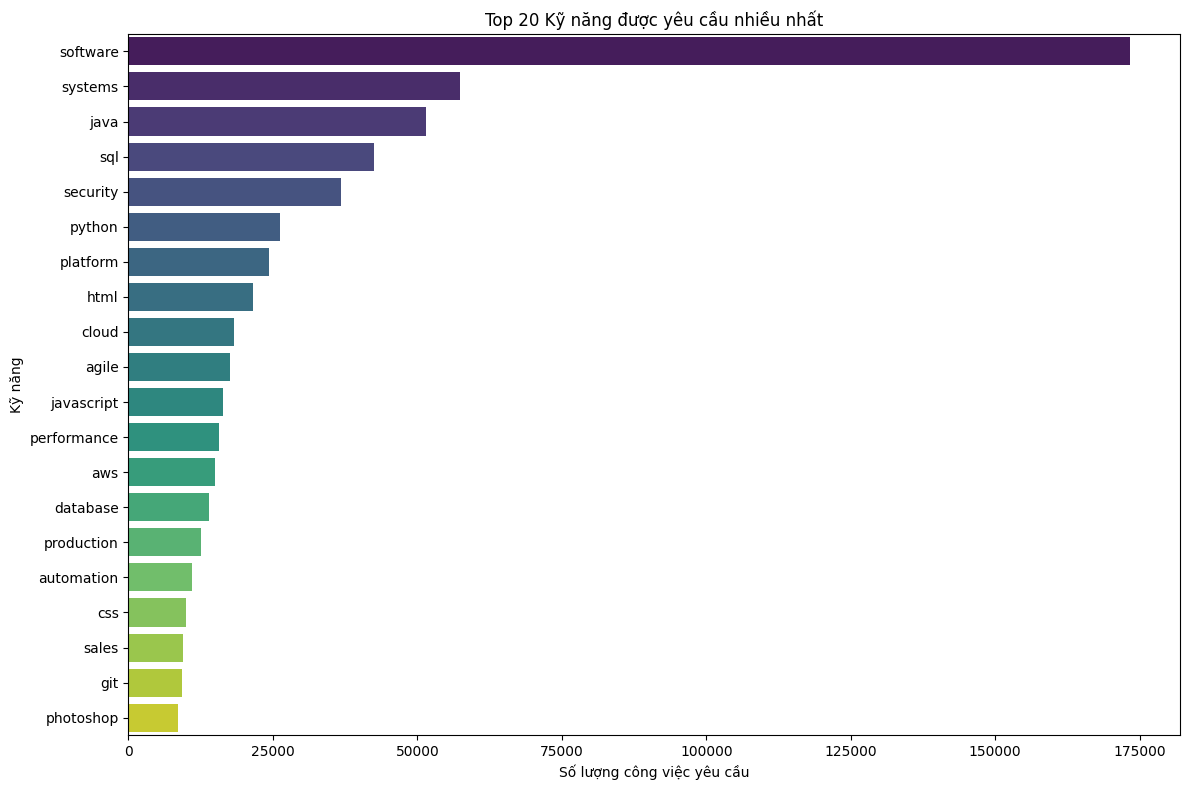

In [30]:
skills_series = df_pairs['primary_skills_cr'].explode().dropna().str.strip()

# Đếm kỹ năng phổ biến nhất
skill_counts = Counter(skills_series)
top_skills = skill_counts.most_common(20)

# Chuyển thành DataFrame để vẽ biểu đồ
skills_df = pd.DataFrame(top_skills, columns=['Skill', 'Count'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Skill', data=skills_df, palette='viridis')
plt.title('Top 20 Kỹ năng được yêu cầu nhiều nhất')
plt.xlabel('Số lượng công việc yêu cầu')
plt.ylabel('Kỹ năng')
plt.tight_layout()
plt.show()

In [31]:
df_pairs.dropna(inplace=True)
df_pairs.to_csv('../../data/clean/clean_resumes_v2.csv', index=False, encoding='utf-8')